In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
import time
import numpy as np
import pandas as pd
import pickle as pkl
import matplotlib.pyplot as plt

import src
from src.reload import deep_reload

np.set_printoptions(suppress=True,precision=5)

In [2]:
import dis
dis.dis('{}')

  0           0 RESUME                   0

  1           2 BUILD_MAP                0
              4 RETURN_VALUE


In [3]:
def Hello():
    print('Hello World')

Hello.__code__.co_code

b'\x97\x00t\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00d\x01\xa6\x01\x00\x00\xab\x01\x00\x00\x00\x00\x00\x00\x00\x00\x01\x00d\x00S\x00'

In [4]:
import dis
dis.dis('dict()')

  0           0 RESUME                   0

  1           2 PUSH_NULL
              4 LOAD_NAME                0 (dict)
              6 PRECALL                  0
             10 CALL                     0
             20 RETURN_VALUE


In [45]:
#Importing itineraries

itineraries=pd.read_pickle('Data/Generated_Data/itineraries.pkl')

In [260]:
[b.destination_charger_power_array[b.is_home] for b in bevs]

[array([0, 0, 0, 0, 0, 0, 0]),
 array([12100,     0,     0,     0,     0,     0,     0]),
 array([    0, 12100,     0,     0,     0,     0,     0]),
 array([12100, 12100,     0,     0,     0,     0,     0]),
 array([    0,     0, 12100,     0,     0,     0,     0]),
 array([12100,     0, 12100,     0,     0,     0,     0]),
 array([    0, 12100, 12100,     0,     0,     0,     0]),
 array([    0,     0,     0, 12100,     0,     0,     0]),
 array([12100,     0,     0, 12100,     0,     0,     0]),
 array([    0, 12100,     0, 12100,     0,     0,     0]),
 array([    0,     0, 12100, 12100,     0,     0,     0]),
 array([    0,     0,     0,     0, 12100,     0,     0]),
 array([12100,     0,     0,     0, 12100,     0,     0]),
 array([    0, 12100,     0,     0, 12100,     0,     0]),
 array([    0,     0, 12100,     0, 12100,     0,     0]),
 array([    0,     0,     0, 12100, 12100,     0,     0]),
 array([    0,     0,     0,     0,     0, 12100,     0]),
 array([12100,     0,    

In [331]:
#Test Simulation
deep_reload(src)

# n=np.random.randint(0,len(itineraries)-1)
# n=146781
# n=12453
# n=142611
# n=26109
print(n)

bev=src.bev_lp.Vehicle(
    itineraries[n]['trips'],
    initial_soc=.5,
    final_soc=.5,
    # en_route_charger_power=0,
    # destination_charger_likelihood=0,
    # home_charger_power=0,
    work_charger_power=0,
    tiles=7,
    )
# print(bev.destination_charger_power_array)

m=20
lkl=.9
bevs,likelihood=src.bev_lp.VehicleFactorial(bev,lkl,m)

6557
39.238


In [332]:
# The problem is solved using PuLP's choice of Solver
deep_reload(src)
import pulp

t0=time.time()
problem=src.bev_lp.StochasticLinearProblem(bevs)

t1=time.time()
solver=pulp.PULP_CBC_CMD(msg=0)
res=problem.solve(solver)

t2=time.time()

solution=src.bev_lp.Solution(problem)
sic_expected=src.bev_lp.ComputeSIC(bevs[0],solution)

t3=time.time()
print(t1-t0,t2-t1,t3-t2)

0.04744076728820801 0.12447381019592285 0.005292177200317383


In [333]:
solution

{'acceb': array([0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0.,
        0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1.]),
 'acced': array([    0.    ,     0.    ,     0.    ,     0.    ,     0.    ,
            0.    ,     0.    ,  4372.8189,     0.    ,     0.    ,
            0.    ,  4372.8189,     0.    ,     0.    ,     0.    ,
         4372.8189,     0.    ,     0.    ,     0.    ,  4372.8189,
            0.    ,     0.    ,     0.    ,  4372.8189,     0.    ,
            0.    ,     0.    , 49140.    ]),
 'dcceb': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 'dcced': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])}

In [311]:
deep_reload(src)
import pulp

t0=time.time()
solver=pulp.PULP_CBC_CMD(msg=0)
sic_mean=src.bev_lp.SolveConstituents(bevs,solver)

t1=time.time()
print(t1-t0)

[0.1319  0.      0.      0.      0.      0.      0.      0.      0.
 0.      0.      0.00678 0.      0.      0.      0.      0.02562 0.
 0.      0.     ]
0.22474002838134766


In [281]:
sic_expected-sic_mean,sic_expected,sic_mean

(0.12368578733006057, 0.13190082727225055, 0.008215039942189984)

3498.25512

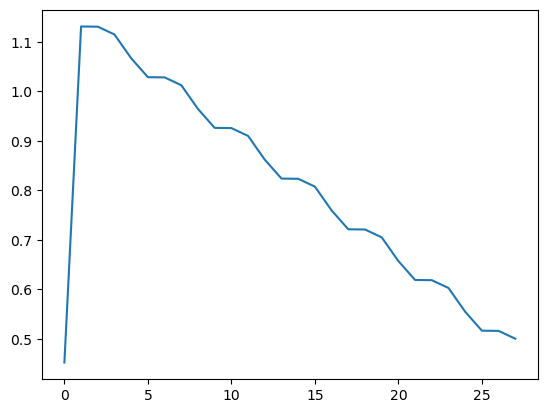

In [282]:
soc=bev.initial_soc+(
    -np.cumsum(bev.discharge_events)+
    np.cumsum(solution['acced']*bev.destination_charger_power_array)+
    np.cumsum(solution['dcced']*bev.en_route_charger_power))/bev.battery_capacity
sic=(
    sum(solution['acceb']*bev.is_other.astype(int)*bev.payment_penalty)+
    sum(solution['dcceb']*(bev.payment_penalty+bev.travel_penalty))+
    sum(solution['dcced']))
plt.plot(soc)
sic

In [326]:
# The problem is solved using PuLP's choice of Solver
deep_reload(src)
import pulp

solver=pulp.PULP_CBC_CMD(msg=0)

t0=time.time()
problem=src.bev_lp.LinearProblem(bevs[5])

t1=time.time()
res=problem.solve(solver)

t2=time.time()
print(t2-t1,t1-t0)
# res

0.010245084762573242 0.0028018951416015625


In [327]:
#Extracting the solution values
deep_reload(src)

solution=src.bev_lp.Solution(problem)
solution

{'acceb': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 'acced': array([    0.   ,     0.   ,     0.   ,     0.   ,     0.   ,     0.   ,
            0.   ,     0.   ,     0.   ,     0.   ,     0.   , 17491.275,
            0.   ,     0.   ,     0.   ,     0.   ,     0.   ,     0.   ,
            0.   ,     0.   ,     0.   ,     0.   ,     0.   ,     0.   ,
            0.   ,     0.   ,     0.   ,     0.   ]),
 'dcceb': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 'dcced': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])}

0.0

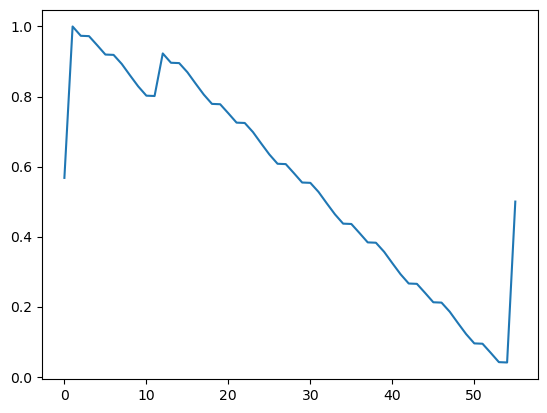

In [100]:
soc=bev.initial_soc+(
    -np.cumsum(bev.discharge_events)+
    np.cumsum(solution['acced']*bev.destination_charger_power_array)+
    np.cumsum(solution['dcced']*bev.en_route_charger_power))/bev.battery_capacity
sic=(
    sum(solution['acceb']*bev.is_other.astype(int)*bev.payment_penalty)+
    sum(solution['dcceb']*(bev.payment_penalty+bev.travel_penalty))+
    sum(solution['dcced']))
plt.plot(soc)
sic